In [23]:
# Read libraries

# Data wrangling
import pandas as pd
import numpy as np
import re
from shapely import wkt
import fiona

# Visualization 
import missingno as msno
import matplotlib
import mapclassify
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.subplots as sp
import plotly.graph_objects as go
import seaborn as sns
import geopandas as gpd

# Machine learning 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.feature_selection import mutual_info_regression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from xgboost import XGBClassifier
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings('ignore')

In [24]:
# Read the GeoParquet file without one-hot sampling
df = pd.read_parquet('df_imputed')

gdf = df

In [25]:
gdf

,year,region,pf_ss_disappearances_disap,pf_ss_disappearances_violent,pf_ss_disappearances_violent_data,pf_ss_disappearances_organized,pf_expression_direct_killed_data,pf_expression_direct_jailed_data,pf_identity_fgm,ef_government,...,ef_regulation_labor_minwage,ef_regulation_labor_hours,ef_regulation_labor_dismissal,ef_regulation_labor_conscription,ef_regulation_business_start,ef_regulation_business_licensing,ef_score,ef_government_tax,pf_expression_bti,pf_rol_civil
0,2020.0,Eastern Europe,10.0,10.000000,0.0,7.50,0.0,0.0,10.0,7.817077,...,5.566667,8.000,6.299741,10.0,9.742477,5.621940,0,0,0,0
1,2020.0,Middle East & North Africa,10.0,9.687083,25.0,5.00,0.0,8.0,10.0,4.409943,...,5.566667,6.000,7.755176,3.0,9.305002,8.771111,0,0,0,0
2,2020.0,Sub-Saharan Africa,10.0,9.582498,25.0,7.50,0.0,0.0,10.0,8.133385,...,10.000000,4.000,6.632764,0.0,8.730805,7.916416,0,0,0,0
3,2020.0,Latin America & the Caribbean,5.0,10.000000,0.0,7.50,0.0,0.0,10.0,6.483768,...,2.766667,10.000,2.517254,10.0,9.579288,5.726521,0,0,0,0
4,2020.0,Caucasus & Central Asia,10.0,10.000000,0.0,7.50,0.0,0.0,10.0,7.975292,...,6.666667,10.000,9.251725,0.0,9.863530,9.302574,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3481,2000.0,Latin America & the Caribbean,10.0,10.000000,0.0,10.00,0.0,0.0,10.0,6.480540,...,4.066480,5.678,0.000000,0.0,6.268547,4.529453,0,0,0,1
3482,2000.0,South Asia,10.0,10.000000,0.0,10.00,0.0,16.0,10.0,7.468423,...,5.600000,8.700,1.934557,0.0,7.885638,2.755084,0,1,0,1
3483,2000.0,Middle East & North Africa,5.0,10.000000,0.0,2.50,0.0,0.0,10.0,7.212284,...,8.900000,8.000,2.517254,0.0,8.735527,8.917008,1,1,0,1
3484,2000.0,Sub-Saharan Africa,10.0,10.000000,0.0,10.00,0.0,2.0,10.0,8.205626,...,10.000000,4.700,0.000000,10.0,8.537578,1.776236,0,0,0,1


## Feature scaling

Feature scaling is a method used to standardize the range of independent variables or features of data. In data processing, it is also known as data normalization and is generally performed during the data preprocessing step.

Note: Before doing feature scaling, make sure to split your data into train and test sets, to avoid data leakage. Data leakage can happen when information from outside your training dataset is used to create the model. This can cause the model to overestimate its accuracy.

First, let's do a **Train-Test Split** with respect to the temporal data nature:

In [26]:
# Sort the data by year
gdf = gdf.sort_values('year')

# Drop the region used for visualization (this is a pure modelling approach)
gdf = gdf.drop(columns=['region'])

gdf.head()

,year,pf_ss_disappearances_disap,pf_ss_disappearances_violent,pf_ss_disappearances_violent_data,pf_ss_disappearances_organized,pf_expression_direct_killed_data,pf_expression_direct_jailed_data,pf_identity_fgm,ef_government,ef_legal_enforcement,...,ef_regulation_labor_minwage,ef_regulation_labor_hours,ef_regulation_labor_dismissal,ef_regulation_labor_conscription,ef_regulation_business_start,ef_regulation_business_licensing,ef_score,ef_government_tax,pf_expression_bti,pf_rol_civil
3485,2000.0,5.0,10.0,0.0,1.25,0.0,0.0,9.5,5.609731,5.430341,...,3.524705,6.847,0.000000,10.0,3.725702,0.000000,0,0,0,1
3378,2000.0,10.0,10.0,0.0,7.50,0.0,0.0,8.0,6.220994,4.953510,...,10.000000,8.000,0.000000,10.0,6.491809,7.321867,0,0,0,1
3377,2000.0,10.0,10.0,0.0,10.00,0.0,0.0,9.5,5.833763,7.651247,...,4.633260,2.505,3.603269,3.0,8.337289,8.766560,0,0,1,1
3376,2000.0,5.0,10.0,0.0,0.00,1.0,0.0,10.0,8.505427,6.692556,...,10.000000,4.000,7.960463,1.0,8.876997,7.738589,0,1,0,1
3375,2000.0,10.0,10.0,0.0,7.50,0.0,0.0,3.0,4.963815,6.499993,...,10.000000,6.000,10.000000,10.0,6.970583,8.237995,1,1,1,1


In [27]:
# Create the X and y variables
X = gdf.drop(['ef_score', 'ef_government_tax', 'pf_expression_bti', 'pf_rol_civil'], axis=1)  # Features
y = gdf[['ef_score', 'ef_government_tax', 'pf_expression_bti', 'pf_rol_civil']]  # Targets

# Calculate the index at which to split the data (60/40 split)
split_index = int(len(X) * 0.6)

# Perform a chronological train-test split
X_temp_train, X_temp_test = X[:split_index], X[split_index:]
y_temp_train, y_temp_test = y[:split_index], y[split_index:]

### Scaling on temporal training and test data

In [28]:
# Separate 'year' from features
year_train = X_temp_train.pop('year')
year_test = X_temp_test.pop('year')

# Initialize a new scaling object for normalizing input variables
scaler = StandardScaler()

# Select only numeric features
X_temp_train_numeric = X_temp_train.select_dtypes(include=np.number)
X_temp_test_numeric = X_temp_test.select_dtypes(include=np.number)

# Fit the scaler object to the training data
scaler.fit(X_temp_train_numeric)

# Apply the scaler object to the training and test sets
X_temp_train_scaled = scaler.transform(X_temp_train_numeric)
X_temp_test_scaled = scaler.transform(X_temp_test_numeric)

# Replace the original numeric columns with the scaled ones
X_temp_train[X_temp_train_numeric.columns] = X_temp_train_scaled
X_temp_test[X_temp_test_numeric.columns] = X_temp_test_scaled

# Add 'year' back to features
X_temp_train['year'] = year_train
X_temp_test['year'] = year_test

### Scaling on stratified training and test data

In [29]:
# Perform stratified train-test split on the original unsorted X and y datasets
X_strat_train, X_strat_test, y_strat_train, y_strat_test = train_test_split(X, y, test_size=0.4, stratify=y, random_state=2)

# Separate 'year' from features
year_strat_train = X_strat_train.pop('year')
year_strat_test = X_strat_test.pop('year')

# Select only numeric features
X_strat_train_numeric = X_strat_train.select_dtypes(include=np.number)
X_strat_test_numeric = X_strat_test.select_dtypes(include=np.number)

# Fit the scaler object to the training data
scaler.fit(X_strat_train_numeric)

# Apply the scaler object to the training and test sets
X_strat_train_scaled = scaler.transform(X_strat_train_numeric)
X_strat_test_scaled = scaler.transform(X_strat_test_numeric)

# Replace the original numeric columns with the scaled ones
X_strat_train[X_strat_train_numeric.columns] = X_strat_train_scaled
X_strat_test[X_strat_test_numeric.columns] = X_strat_test_scaled

# Add 'year' back to features
X_strat_train['year'] = year_strat_train
X_strat_test['year'] = year_strat_test

In [30]:
# Class balance for temporal sampling
ef_score_temporal_balance = y_temp_train['ef_score'].value_counts(normalize=True)
print("Class balance for temporal sampling (ef_score):\n", ef_score_temporal_balance)

# Class balance for stratified sampling
ef_score_stratified_balance = y_strat_train['ef_score'].value_counts(normalize=True)
print("Class balance for stratified sampling (ef_score):\n", ef_score_stratified_balance)

Class balance for temporal sampling (ef_score):
 0    0.832616
1    0.167384
Name: ef_score, dtype: float64
Class balance for stratified sampling (ef_score):
 0    0.890483
1    0.109517
Name: ef_score, dtype: float64


In [31]:
# Class balance for temporal sampling
ef_score_temporal_balance = y_temp_test['ef_score'].value_counts(normalize=True)
print("Class balance for temporal sampling (ef_score):\n", ef_score_temporal_balance)

# Class balance for stratified sampling
ef_score_stratified_balance = y_strat_test['ef_score'].value_counts(normalize=True)
print("Class balance for stratified sampling (ef_score):\n", ef_score_stratified_balance)

Class balance for temporal sampling (ef_score):
 0    0.977061
1    0.022939
Name: ef_score, dtype: float64
Class balance for stratified sampling (ef_score):
 0    0.890323
1    0.109677
Name: ef_score, dtype: float64


## Feature selection optimization (Random Forest with genetic mutation)

In [32]:
from sklearn.ensemble import RandomForestClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.pipeline import Pipeline

def feature_selection(X_train, y_train, cv):
    # Initialize a random forest model
    model = RandomForestClassifier(n_estimators=100, random_state=42)

    # Initialize a dictionary to store selected features and their importance for each target
    selected_features_dict = {}

    # Perform Sequential Feature Selection for each target
    for i, target in enumerate(y_train.columns):
        print(f"\nStarting feature selection for target {i+1}/{len(y_train.columns)}: {target}")
        
        # Create a pipeline with SFS
        pipeline = Pipeline(steps=[('sfs', SFS(estimator=model, 
                                                k_features=(1,6), 
                                                forward=True, 
                                                floating=False, 
                                                scoring='accuracy',
                                                cv=cv,
                                                n_jobs=-1))])
        print("Created the pipeline.")

        # Fit the pipeline to the data
        pipeline.fit(X_train, y_train[target])
        print("Fitted the pipeline to the data.")

        # Get the features selected by SFS
        selected_features = X_train.columns[list(pipeline.named_steps['sfs'].k_feature_idx_)]
        print("Got the selected features.")

        # Fit the model on all selected features at once and get the feature importances
        model.fit(X_train[selected_features], y_train[target])
        feature_importances = model.feature_importances_
        print("Fitted the model and got the feature importances.")

        # Create a mapping from features to feature importances
        feature_stats = dict(zip(selected_features, feature_importances))
        print("Created a mapping from features to feature importances.")

        # Append the selected features and their importance to the dictionary
        selected_features_dict[target] = feature_stats
        print("Appended the selected features and their importance to the dictionary.")

    print("\nFeature selection completed for all targets.\n")

    # Print the names and importance of the final selected features for each target
    for target, features in selected_features_dict.items():
        print(f"Target: {target}")
        for feature, importance in features.items():
            print(f"Feature: {feature}, Importance: {importance}")
        print()
    
    return selected_features_dict

In [33]:
from sklearn.model_selection import StratifiedKFold

strat_kfold = StratifiedKFold(n_splits=5)

selected_features_dict_stratified = feature_selection(X_strat_train, y_strat_train, cv=strat_kfold)


Starting feature selection for target 1/4: ef_score
Created the pipeline.
Fitted the pipeline to the data.
Got the selected features.
Fitted the model and got the feature importances.
Created a mapping from features to feature importances.
Appended the selected features and their importance to the dictionary.

Starting feature selection for target 2/4: ef_government_tax
Created the pipeline.
Fitted the pipeline to the data.
Got the selected features.
Fitted the model and got the feature importances.
Created a mapping from features to feature importances.
Appended the selected features and their importance to the dictionary.

Starting feature selection for target 3/4: pf_expression_bti
Created the pipeline.
Fitted the pipeline to the data.
Got the selected features.
Fitted the model and got the feature importances.
Created a mapping from features to feature importances.
Appended the selected features and their importance to the dictionary.

Starting feature selection for target 4/4: pf

In [34]:
from sklearn.model_selection import TimeSeriesSplit

# Create a TimeSeriesSplit object
tscv = TimeSeriesSplit(n_splits=5)

# Call the feature_selection function with the TimeSeriesSplit object
selected_features_dict_temporal = feature_selection(X_temp_train, y_temp_train, cv=tscv)


Starting feature selection for target 1/4: ef_score
Created the pipeline.
Fitted the pipeline to the data.
Got the selected features.
Fitted the model and got the feature importances.
Created a mapping from features to feature importances.
Appended the selected features and their importance to the dictionary.

Starting feature selection for target 2/4: ef_government_tax
Created the pipeline.
Fitted the pipeline to the data.
Got the selected features.
Fitted the model and got the feature importances.
Created a mapping from features to feature importances.
Appended the selected features and their importance to the dictionary.

Starting feature selection for target 3/4: pf_expression_bti
Created the pipeline.
Fitted the pipeline to the data.
Got the selected features.
Fitted the model and got the feature importances.
Created a mapping from features to feature importances.
Appended the selected features and their importance to the dictionary.

Starting feature selection for target 4/4: pf

Feature selection: Mutual Information

In [35]:
selected_features_dict_temporal

{'ef_score': {'pf_ss_disappearances_violent_data': 0.0361558350728881,
  'ef_money_sd': 0.24955408880699526,
  'ef_regulation_labor_dismissal': 0.17981983707096993,
  'ef_regulation_business_start': 0.19684933911354036,
  'ef_regulation_business_licensing': 0.23813032679910942,
  'year': 0.09949057313649692},
 'ef_government_tax': {'pf_identity_fgm': 0.16841386760196442,
  'ef_gender': 0.15135286038489515,
  'ef_trade_tariffs_sd_data': 0.19707888036792032,
  'ef_regulation_labor_dismissal': 0.17227272998327764,
  'ef_regulation_business_start': 0.21328316487343776,
  'year': 0.09759849678850475},
 'pf_expression_bti': {'pf_ss_disappearances_organized': 0.12419873561805998,
  'ef_legal_enforcement': 0.22699211280325737,
  'ef_legal_regulatory': 0.16517703826608038,
  'ef_gender': 0.13650182559278537,
  'ef_regulation_labor_dismissal': 0.19501118197422573,
  'ef_regulation_business_licensing': 0.1521191057455912},
 'pf_rol_civil': {'pf_identity_fgm': 0.04521038839022992,
  'ef_legal_enfo

Remember, mutual information is a filter method that measures the statistical dependency between two variables, but it doesn't take into account the potential relationships between different features, while RFE is a wrapper method that takes into account the potential relationships between different features by using a specific model to evaluate the importance of each feature. Therefore, these methods can give different results, and using them together can give a more comprehensive view of feature importance.

Feature selection: Backward feature selection

**Time-series validation**: The method is also known as "rolling forecasting origin" or "walk-forward validation" in the context of time series forecasting

## Modelling: Statistical

### Logistic Regression (model baseline)

In [36]:
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression

def train_and_evaluate_models(selected_features_dict, X_train, X_test, y_train, y_test):
    
    # Initialize a dictionary to store models
    models = {}

    for target in selected_features_dict.keys():
        print(f"\nTraining model for {target}")

        # Get the best features for the target
        best_features = list(selected_features_dict[target].keys())

        # Subset X_train and X_test to only include the best features
        X_train_best = X_train[best_features]
        X_test_best = X_test[best_features]

        # Fit the model
        clf = LogisticRegression(random_state=0).fit(X_train_best, y_train[target])

        # Store the model
        models[target] = clf

        # Make predictions and evaluate
        y_pred = clf.predict(X_test_best)
        print(classification_report(y_test[target], y_pred))

    return models


In [37]:
models_temporal = train_and_evaluate_models(selected_features_dict_temporal, X_temp_train, X_temp_test, y_temp_train, y_temp_test)


Training model for ef_score
              precision    recall  f1-score   support

           0       0.98      0.97      0.97      1363
           1       0.14      0.22      0.17        32

    accuracy                           0.95      1395
   macro avg       0.56      0.59      0.57      1395
weighted avg       0.96      0.95      0.96      1395


Training model for ef_government_tax
              precision    recall  f1-score   support

           0       0.99      0.94      0.96      1363
           1       0.17      0.56      0.26        32

    accuracy                           0.93      1395
   macro avg       0.58      0.75      0.61      1395
weighted avg       0.97      0.93      0.95      1395


Training model for pf_expression_bti
              precision    recall  f1-score   support

           0       0.86      0.89      0.88      1037
           1       0.66      0.59      0.62       358

    accuracy                           0.82      1395
   macro avg       0.76

In [38]:
models_stratified = train_and_evaluate_models(selected_features_dict_stratified, X_strat_train, X_strat_test, y_strat_train, y_strat_test)


Training model for ef_score
              precision    recall  f1-score   support

           0       0.89      1.00      0.94      1242
           1       0.33      0.01      0.03       153

    accuracy                           0.89      1395
   macro avg       0.61      0.50      0.48      1395
weighted avg       0.83      0.89      0.84      1395


Training model for ef_government_tax
              precision    recall  f1-score   support

           0       0.87      0.98      0.92      1168
           1       0.72      0.26      0.39       227

    accuracy                           0.86      1395
   macro avg       0.80      0.62      0.66      1395
weighted avg       0.85      0.86      0.84      1395


Training model for pf_expression_bti
              precision    recall  f1-score   support

           0       0.81      0.92      0.86       998
           1       0.70      0.45      0.55       397

    accuracy                           0.79      1395
   macro avg       0.75

### Random Forest & XGBoost with GridSearch optimization

In [39]:
from sklearn.metrics import roc_auc_score, matthews_corrcoef, balanced_accuracy_score
from sklearn.preprocessing import LabelBinarizer

def classification_report_to_dict(target, y_true, y_pred, y_pred_proba, feature_importances, cv_method, feature_names):
    
    # Note: You might need to adapt this to your specific context
    lb = LabelBinarizer()
    y_true_bin = lb.fit_transform(y_true)
    y_pred_bin = lb.transform(y_pred)

    scores = classification_report(y_true, y_pred, output_dict=True)
    accuracy = accuracy_score(y_true, y_pred)
    balanced_accuracy = balanced_accuracy_score(y_true, y_pred)
    macro_f1 = scores['macro avg']['f1-score']
    roc_auc = roc_auc_score(y_true_bin, y_pred_proba[:, 1])
    matthews_corr = matthews_corrcoef(y_true, y_pred)
    
    # Indices of features sorted by importance
    top_features = np.argsort(feature_importances)[::-1]  
    reports = []
    
    for class_label, metrics in scores.items():
        if class_label.isdigit():  # only process class labels, skip 'accuracy', 'macro avg' and 'weighted avg'
            report_dict = {
                'target': target,
                'class_label': class_label,
                'precision': metrics['precision'],
                'recall': metrics['recall'],
                'f1_score': metrics['f1-score'],
                'accuracy': accuracy,
                'balanced_accuracy': balanced_accuracy,
                'macro_f1': macro_f1,
                'roc_auc': roc_auc,
                'matthews_corr': matthews_corr,
                'cv_method': cv_method,
                'top1_feature': feature_names[top_features[0]] if len(top_features) > 0 else None,
                'top2_feature': feature_names[top_features[1]] if len(top_features) > 1 else None,
                'top3_feature': feature_names[top_features[2]] if len(top_features) > 2 else None
            }
            reports.append(report_dict)
    return reports

In [40]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import plotly.graph_objects as go
from sklearn.metrics import classification_report

# Initialize dictionaries to store the best models
best_models_rf = {}
best_models_xgb = {}
best_models_nn = {}
best_models_svm = {}

rf_params = {
    'n_estimators': [5, 10, 20],
    'max_depth': [2, 3, 4],
    'min_samples_split': [5, 10, 15]
}

xgb_params = {
    'n_estimators': [5, 10, 20],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [2, 3, 4],
    'gamma': [0, 0.1, 0.2]
}

nn_params = {
    'hidden_layer_sizes': [50, 100, 150],  # Single hidden layer
    'learning_rate_init': [0.01, 0.001, 0.0001],
    'max_iter': [200, 300, 400],
    'alpha': [0.0001, 0.001, 0.01, 0.1],  # L2 penalty (regularization term) parameter
}

svm_params = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 1, 0.1, 0.01, 0.001],
    'kernel': ['linear', 'rbf', 'poly']
}


def model(X_train, X_test, y_train, y_test, selected_features_dict, cv, cv_method_name, results_df=None):
    results = []

    for target in selected_features_dict.keys():
        print(f"\nPerforming grid search for models for {target}")

        # Get the best features for the target
        best_features = list(selected_features_dict[target].keys())

        # Subset X_train and X_test to only include the best features
        X_train_best = X_train[best_features]
        X_test_best = X_test[best_features]

        # Random Forest model
        print("Performing grid search for Random Forest Model")
        rf_grid = GridSearchCV(RandomForestClassifier(random_state=2), rf_params, cv=cv)
        rf_grid.fit(X_train_best, y_train[target])
        best_models_rf[target] = rf_grid.best_estimator_
        y_pred_rf = best_models_rf[target].predict(X_test_best)
        y_pred_proba_rf = best_models_rf[target].predict_proba(X_test_best)

        
        print(f"\nClassification report for Random Forest model, {target}")
        print(classification_report(y_test[target], y_pred_rf))

        # Save metrics and feature importance
        results_rf = classification_report_to_dict(target, y_test[target], y_pred_rf, y_pred_proba_rf, best_models_rf[target].feature_importances_, cv_method_name, X_train_best.columns)
        for result in results_rf:
            result['model'] = 'RandomForest'
            results.append(result)

        # XGBoost model
        print("Performing grid search for XGBoost Model")
        xgb_grid = GridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric="logloss"), xgb_params, cv=cv)
        xgb_grid.fit(X_train_best, y_train[target])
        best_models_xgb[target] = xgb_grid.best_estimator_
        y_pred_xgb = best_models_xgb[target].predict(X_test_best)
        y_pred_proba_xgb = best_models_xgb[target].predict_proba(X_test_best)
        print(f"\nClassification report for XGBoost model, {target}")
        print(classification_report(y_test[target], y_pred_xgb))

        # Save metrics and feature importance
        results_xgb = classification_report_to_dict(target, y_test[target], y_pred_xgb, y_pred_proba_xgb, best_models_xgb[target].feature_importances_, cv_method_name, X_train_best.columns)
        for result in results_xgb:
            result['model'] = 'XGBoost'
            results.append(result)

        # Neural Network model
        print("Performing grid search for Neural Network Model")
        nn_grid = GridSearchCV(MLPClassifier(random_state=0), nn_params, cv=cv)
        nn_grid.fit(X_train_best, y_train[target])
        best_models_nn[target] = nn_grid.best_estimator_
        y_pred_nn = best_models_nn[target].predict(X_test_best)
        y_pred_proba_nn = best_models_nn[target].predict_proba(X_test_best)
        feature_importances_nn = np.mean(np.abs(best_models_nn[target].coefs_[0]), axis=1)
        top_features_nn = np.argsort(feature_importances_nn)[::-1]  # Indices of features sorted by importance
        print(f"\nClassification report for Neural Network model, {target}")
        print(classification_report(y_test[target], y_pred_nn))

        # Save metrics and approximate feature importance
        results_nn = classification_report_to_dict(target, y_test[target], y_pred_nn, y_pred_proba_nn, top_features_nn, cv_method_name, X_train_best.columns)
        for result in results_nn:
            result['model'] = 'NeuralNetwork'
            results.append(result)
            
            # SVM model
        print("Performing grid search for SVM Model")
        svm_grid = GridSearchCV(SVC(random_state=2, probability=True, class_weight='balanced'), svm_params, cv=cv)
        svm_grid.fit(X_train_best, y_train[target])
        best_models_svm[target] = svm_grid.best_estimator_
        y_pred_svm = best_models_svm[target].predict(X_test_best)
        y_pred_proba_svm = best_models_svm[target].predict_proba(X_test_best)

        print(f"\nClassification report for SVM model, {target}")
        print(classification_report(y_test[target], y_pred_svm))

        # Save metrics
        results_svm = classification_report_to_dict(target, y_test[target], y_pred_svm, y_pred_proba_svm, None, cv_method_name, X_train_best.columns)
        for result in results_svm:
            result['model'] = 'SVM'
            results.append(result)
            
    # If results_df was provided, append new results to it; otherwise create a new DataFrame
    if results_df is not None:
        results_df = pd.concat([results_df, pd.DataFrame(results)], ignore_index=True)
    else:
        results_df = pd.DataFrame(results)

    return results_df, best_models_rf, best_models_xgb, best_models_nn

In [41]:
tscv = TimeSeriesSplit(n_splits=5)
results_df, best_models_rf_temporal, best_models_xgb_temporal, best_models_nn_temporal = model(X_temp_train, X_temp_test, y_temp_train, y_temp_test, selected_features_dict_temporal, cv=tscv, cv_method_name="TimeSeriesSplit")

skf = StratifiedKFold(n_splits=5)
results_df, best_models_rf_stratified, best_models_xgb_stratified, best_models_nn_stratified = model(X_strat_train, X_strat_test, y_strat_train, y_strat_test, selected_features_dict_stratified, cv=skf, cv_method_name="StratifiedSplit", results_df=results_df)


Performing grid search for models for ef_score
Performing grid search for Random Forest Model

Classification report for Random Forest model, ef_score
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1363
           1       0.27      0.47      0.34        32

    accuracy                           0.96      1395
   macro avg       0.63      0.72      0.66      1395
weighted avg       0.97      0.96      0.96      1395

Performing grid search for XGBoost Model

Classification report for XGBoost model, ef_score
              precision    recall  f1-score   support

           0       0.99      0.94      0.97      1363
           1       0.23      0.72      0.35        32

    accuracy                           0.94      1395
   macro avg       0.61      0.83      0.66      1395
weighted avg       0.98      0.94      0.95      1395

Performing grid search for Neural Network Model

Classification report for Neural Network model, ef_sc

In [42]:
results_df

,target,class_label,precision,recall,f1_score,accuracy,balanced_accuracy,macro_f1,roc_auc,matthews_corr,cv_method,top1_feature,top2_feature,top3_feature,model
0,ef_score,0,0.987313,0.970653,0.978912,0.959140,0.719701,0.661870,0.909552,0.338028,TimeSeriesSplit,ef_money_sd,ef_regulation_business_start,ef_regulation_business_licensing,RandomForest
1,ef_score,1,0.272727,0.468750,0.344828,0.959140,0.719701,0.661870,0.909552,0.338028,TimeSeriesSplit,ef_money_sd,ef_regulation_business_start,ef_regulation_business_licensing,RandomForest
2,ef_score,0,0.993045,0.942773,0.967256,0.937634,0.830762,0.656560,0.955945,0.382156,TimeSeriesSplit,ef_money_sd,ef_regulation_business_licensing,ef_regulation_labor_dismissal,XGBoost
3,ef_score,1,0.227723,0.718750,0.345865,0.937634,0.830762,0.656560,0.955945,0.382156,TimeSeriesSplit,ef_money_sd,ef_regulation_business_licensing,ef_regulation_labor_dismissal,XGBoost
4,ef_score,0,0.981536,0.975055,0.978285,0.957706,0.596903,0.585033,0.748968,0.171786,TimeSeriesSplit,ef_regulation_business_licensing,pf_ss_disappearances_violent_data,year,NeuralNetwork
5,ef_score,1,0.170732,0.218750,0.191781,0.957706,0.596903,0.585033,0.748968,0.171786,TimeSeriesSplit,ef_regulation_business_licensing,pf_ss_disappearances_violent_data,year,NeuralNetwork
6,ef_government_tax,0,0.988864,0.977256,0.983026,0.967025,0.754253,0.704013,0.916418,0.417652,TimeSeriesSplit,pf_identity_fgm,ef_gender,ef_regulation_labor_dismissal,RandomForest
7,ef_government_tax,1,0.354167,0.531250,0.425000,0.967025,0.754253,0.704013,0.916418,0.417652,TimeSeriesSplit,pf_identity_fgm,ef_gender,ef_regulation_labor_dismissal,RandomForest
8,ef_government_tax,0,0.989683,0.985326,0.987500,0.975627,0.773913,0.750893,0.935838,0.503830,TimeSeriesSplit,pf_identity_fgm,ef_gender,ef_regulation_labor_dismissal,XGBoost
9,ef_government_tax,1,0.473684,0.562500,0.514286,0.975627,0.773913,0.750893,0.935838,0.503830,TimeSeriesSplit,pf_identity_fgm,ef_gender,ef_regulation_labor_dismissal,XGBoost


In [43]:
# Add a surname to the dataframe for later purposes
results_df['data'] = 'imputed'

In [44]:
# Export the dataframe to be loaded in the application for the interface
results_df.to_csv('results_imputed.csv', index=False)

In [22]:
tscv = TimeSeriesSplit(n_splits=5)

# With temporal sampling
best_models_rf_temporal, best_models_xgb_temporal, best_models_nn_temporal = model(X_temp_train, X_temp_test, y_temp_train, y_temp_test, selected_features_dict_temporal, cv=tscv)


Performing grid search for models for ef_score
Performing grid search for Random Forest Model

Classification report for Random Forest model, ef_score
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1363
           1       0.35      0.34      0.35        32

    accuracy                           0.97      1395
   macro avg       0.67      0.66      0.67      1395
weighted avg       0.97      0.97      0.97      1395



Performing grid search for XGBoost Model

Classification report for XGBoost model, ef_score
              precision    recall  f1-score   support

           0       0.99      0.95      0.97      1363
           1       0.27      0.78      0.41        32

    accuracy                           0.95      1395
   macro avg       0.63      0.87      0.69      1395
weighted avg       0.98      0.95      0.96      1395



Performing grid search for Neural Network Model

Classification report for Neural Network model, ef_score
              precision    recall  f1-score   support

           0       1.00      0.95      0.97      1363
           1       0.30      0.88      0.45        32

    accuracy                           0.95      1395
   macro avg       0.65      0.91      0.71      1395
weighted avg       0.98      0.95      0.96      1395




Performing grid search for models for hf_score
Performing grid search for Random Forest Model

Classification report for Random Forest model, hf_score
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1363
           1       0.35      0.34      0.35        32

    accuracy                           0.97      1395
   macro avg       0.67      0.66      0.67      1395
weighted avg       0.97      0.97      0.97      1395



Performing grid search for XGBoost Model

Classification report for XGBoost model, hf_score
              precision    recall  f1-score   support

           0       0.99      0.95      0.97      1363
           1       0.27      0.78      0.41        32

    accuracy                           0.95      1395
   macro avg       0.63      0.87      0.69      1395
weighted avg       0.98      0.95      0.96      1395



Performing grid search for Neural Network Model

Classification report for Neural Network model, hf_score
              precision    recall  f1-score   support

           0       1.00      0.95      0.97      1363
           1       0.30      0.88      0.45        32

    accuracy                           0.95      1395
   macro avg       0.65      0.91      0.71      1395
weighted avg       0.98      0.95      0.96      1395




Performing grid search for models for pf_expression_bti
Performing grid search for Random Forest Model

Classification report for Random Forest model, pf_expression_bti
              precision    recall  f1-score   support

           0       0.83      0.96      0.89      1037
           1       0.77      0.42      0.54       358

    accuracy                           0.82      1395
   macro avg       0.80      0.69      0.71      1395
weighted avg       0.81      0.82      0.80      1395



Performing grid search for XGBoost Model

Classification report for XGBoost model, pf_expression_bti
              precision    recall  f1-score   support

           0       0.87      0.94      0.91      1037
           1       0.78      0.60      0.68       358

    accuracy                           0.85      1395
   macro avg       0.82      0.77      0.79      1395
weighted avg       0.85      0.85      0.85      1395



Performing grid search for Neural Network Model

Classification report for Neural Network model, pf_expression_bti
              precision    recall  f1-score   support

           0       0.87      0.90      0.88      1037
           1       0.68      0.59      0.63       358

    accuracy                           0.82      1395
   macro avg       0.77      0.75      0.76      1395
weighted avg       0.82      0.82      0.82      1395




Performing grid search for models for pf_rol_civil
Performing grid search for Random Forest Model

Classification report for Random Forest model, pf_rol_civil
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       956
           1       0.31      1.00      0.48       439

    accuracy                           0.31      1395
   macro avg       0.16      0.50      0.24      1395
weighted avg       0.10      0.31      0.15      1395



Performing grid search for XGBoost Model

Classification report for XGBoost model, pf_rol_civil
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       956
           1       0.31      1.00      0.48       439

    accuracy                           0.31      1395
   macro avg       0.16      0.50      0.24      1395
weighted avg       0.10      0.31      0.15      1395



Performing grid search for Neural Network Model

Classification report for Neural Network model, pf_rol_civil
              precision    recall  f1-score   support

           0       0.94      0.30      0.46       956
           1       0.39      0.96      0.55       439

    accuracy                           0.51      1395
   macro avg       0.66      0.63      0.51      1395
weighted avg       0.77      0.51      0.49      1395



In [23]:
skf = StratifiedKFold(n_splits=5)

# With stratified sampling
best_models_rf_stratified, best_models_xgb_stratified, best_models_nn_stratified = model(X_strat_train, X_strat_test, y_strat_train, y_strat_test, selected_features_dict_stratified, cv =skf)


Performing grid search for models for ef_score
Performing grid search for Random Forest Model

Classification report for Random Forest model, ef_score
              precision    recall  f1-score   support

           0       0.90      1.00      0.95      1242
           1       0.90      0.12      0.22       153

    accuracy                           0.90      1395
   macro avg       0.90      0.56      0.58      1395
weighted avg       0.90      0.90      0.87      1395



Performing grid search for XGBoost Model

Classification report for XGBoost model, ef_score
              precision    recall  f1-score   support

           0       0.94      0.99      0.96      1242
           1       0.90      0.46      0.61       153

    accuracy                           0.94      1395
   macro avg       0.92      0.73      0.79      1395
weighted avg       0.93      0.94      0.93      1395



Performing grid search for Neural Network Model

Classification report for Neural Network model, ef_score
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1242
           1       0.77      0.93      0.85       153

    accuracy                           0.96      1395
   macro avg       0.88      0.95      0.91      1395
weighted avg       0.97      0.96      0.96      1395




Performing grid search for models for hf_score
Performing grid search for Random Forest Model

Classification report for Random Forest model, hf_score
              precision    recall  f1-score   support

           0       0.90      1.00      0.95      1242
           1       0.90      0.12      0.22       153

    accuracy                           0.90      1395
   macro avg       0.90      0.56      0.58      1395
weighted avg       0.90      0.90      0.87      1395



Performing grid search for XGBoost Model

Classification report for XGBoost model, hf_score
              precision    recall  f1-score   support

           0       0.94      0.99      0.96      1242
           1       0.90      0.46      0.61       153

    accuracy                           0.94      1395
   macro avg       0.92      0.73      0.79      1395
weighted avg       0.93      0.94      0.93      1395



Performing grid search for Neural Network Model

Classification report for Neural Network model, hf_score
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1242
           1       0.77      0.93      0.85       153

    accuracy                           0.96      1395
   macro avg       0.88      0.95      0.91      1395
weighted avg       0.97      0.96      0.96      1395




Performing grid search for models for pf_expression_bti
Performing grid search for Random Forest Model

Classification report for Random Forest model, pf_expression_bti
              precision    recall  f1-score   support

           0       0.83      0.96      0.89       998
           1       0.82      0.51      0.63       397

    accuracy                           0.83      1395
   macro avg       0.83      0.73      0.76      1395
weighted avg       0.83      0.83      0.82      1395



Performing grid search for XGBoost Model

Classification report for XGBoost model, pf_expression_bti
              precision    recall  f1-score   support

           0       0.87      0.97      0.92       998
           1       0.90      0.62      0.73       397

    accuracy                           0.87      1395
   macro avg       0.88      0.80      0.82      1395
weighted avg       0.87      0.87      0.86      1395



Performing grid search for Neural Network Model

Classification report for Neural Network model, pf_expression_bti
              precision    recall  f1-score   support

           0       0.98      0.86      0.91       998
           1       0.73      0.95      0.82       397

    accuracy                           0.88      1395
   macro avg       0.85      0.90      0.87      1395
weighted avg       0.91      0.88      0.89      1395




Performing grid search for models for pf_rol_civil
Performing grid search for Random Forest Model

Classification report for Random Forest model, pf_rol_civil
              precision    recall  f1-score   support

           0       0.72      0.67      0.69       561
           1       0.79      0.82      0.80       834

    accuracy                           0.76      1395
   macro avg       0.75      0.75      0.75      1395
weighted avg       0.76      0.76      0.76      1395



Performing grid search for XGBoost Model

Classification report for XGBoost model, pf_rol_civil
              precision    recall  f1-score   support

           0       0.77      0.73      0.75       561
           1       0.83      0.85      0.84       834

    accuracy                           0.80      1395
   macro avg       0.80      0.79      0.79      1395
weighted avg       0.80      0.80      0.80      1395



Performing grid search for Neural Network Model

Classification report for Neural Network model, pf_rol_civil
              precision    recall  f1-score   support

           0       0.87      0.83      0.85       561
           1       0.89      0.92      0.90       834

    accuracy                           0.88      1395
   macro avg       0.88      0.88      0.88      1395
weighted avg       0.88      0.88      0.88      1395



[Text(0.58, 0.9, 'pf_ss_disappearances_violent_data <= -0.041\ngini = 0.191\nsamples = 1333\nvalue = [1867, 224]\nclass = ef_score'),
 Text(0.32, 0.7, 'pf_ss_disappearances_organized <= 0.62\ngini = 0.339\nsamples = 406\nvalue = [504, 139]\nclass = ef_score'),
 Text(0.16, 0.5, 'pf_expression_direct_jailed_data <= 1.077\ngini = 0.391\nsamples = 310\nvalue = [358, 130]\nclass = ef_score'),
 Text(0.08, 0.3, 'pf_ss_disappearances_organized <= 0.591\ngini = 0.335\nsamples = 281\nvalue = [347, 94]\nclass = ef_score'),
 Text(0.04, 0.1, 'gini = 0.316\nsamples = 271\nvalue = [343, 84]\nclass = ef_score'),
 Text(0.12, 0.1, 'gini = 0.408\nsamples = 10\nvalue = [4, 10]\nclass = hf_score'),
 Text(0.24, 0.3, 'pf_expression_direct_killed_data <= 0.581\ngini = 0.359\nsamples = 29\nvalue = [11, 36]\nclass = hf_score'),
 Text(0.2, 0.1, 'gini = 0.0\nsamples = 10\nvalue = [0, 20]\nclass = hf_score'),
 Text(0.28, 0.1, 'gini = 0.483\nsamples = 19\nvalue = [11, 16]\nclass = hf_score'),
 Text(0.48, 0.5, 'pf_e

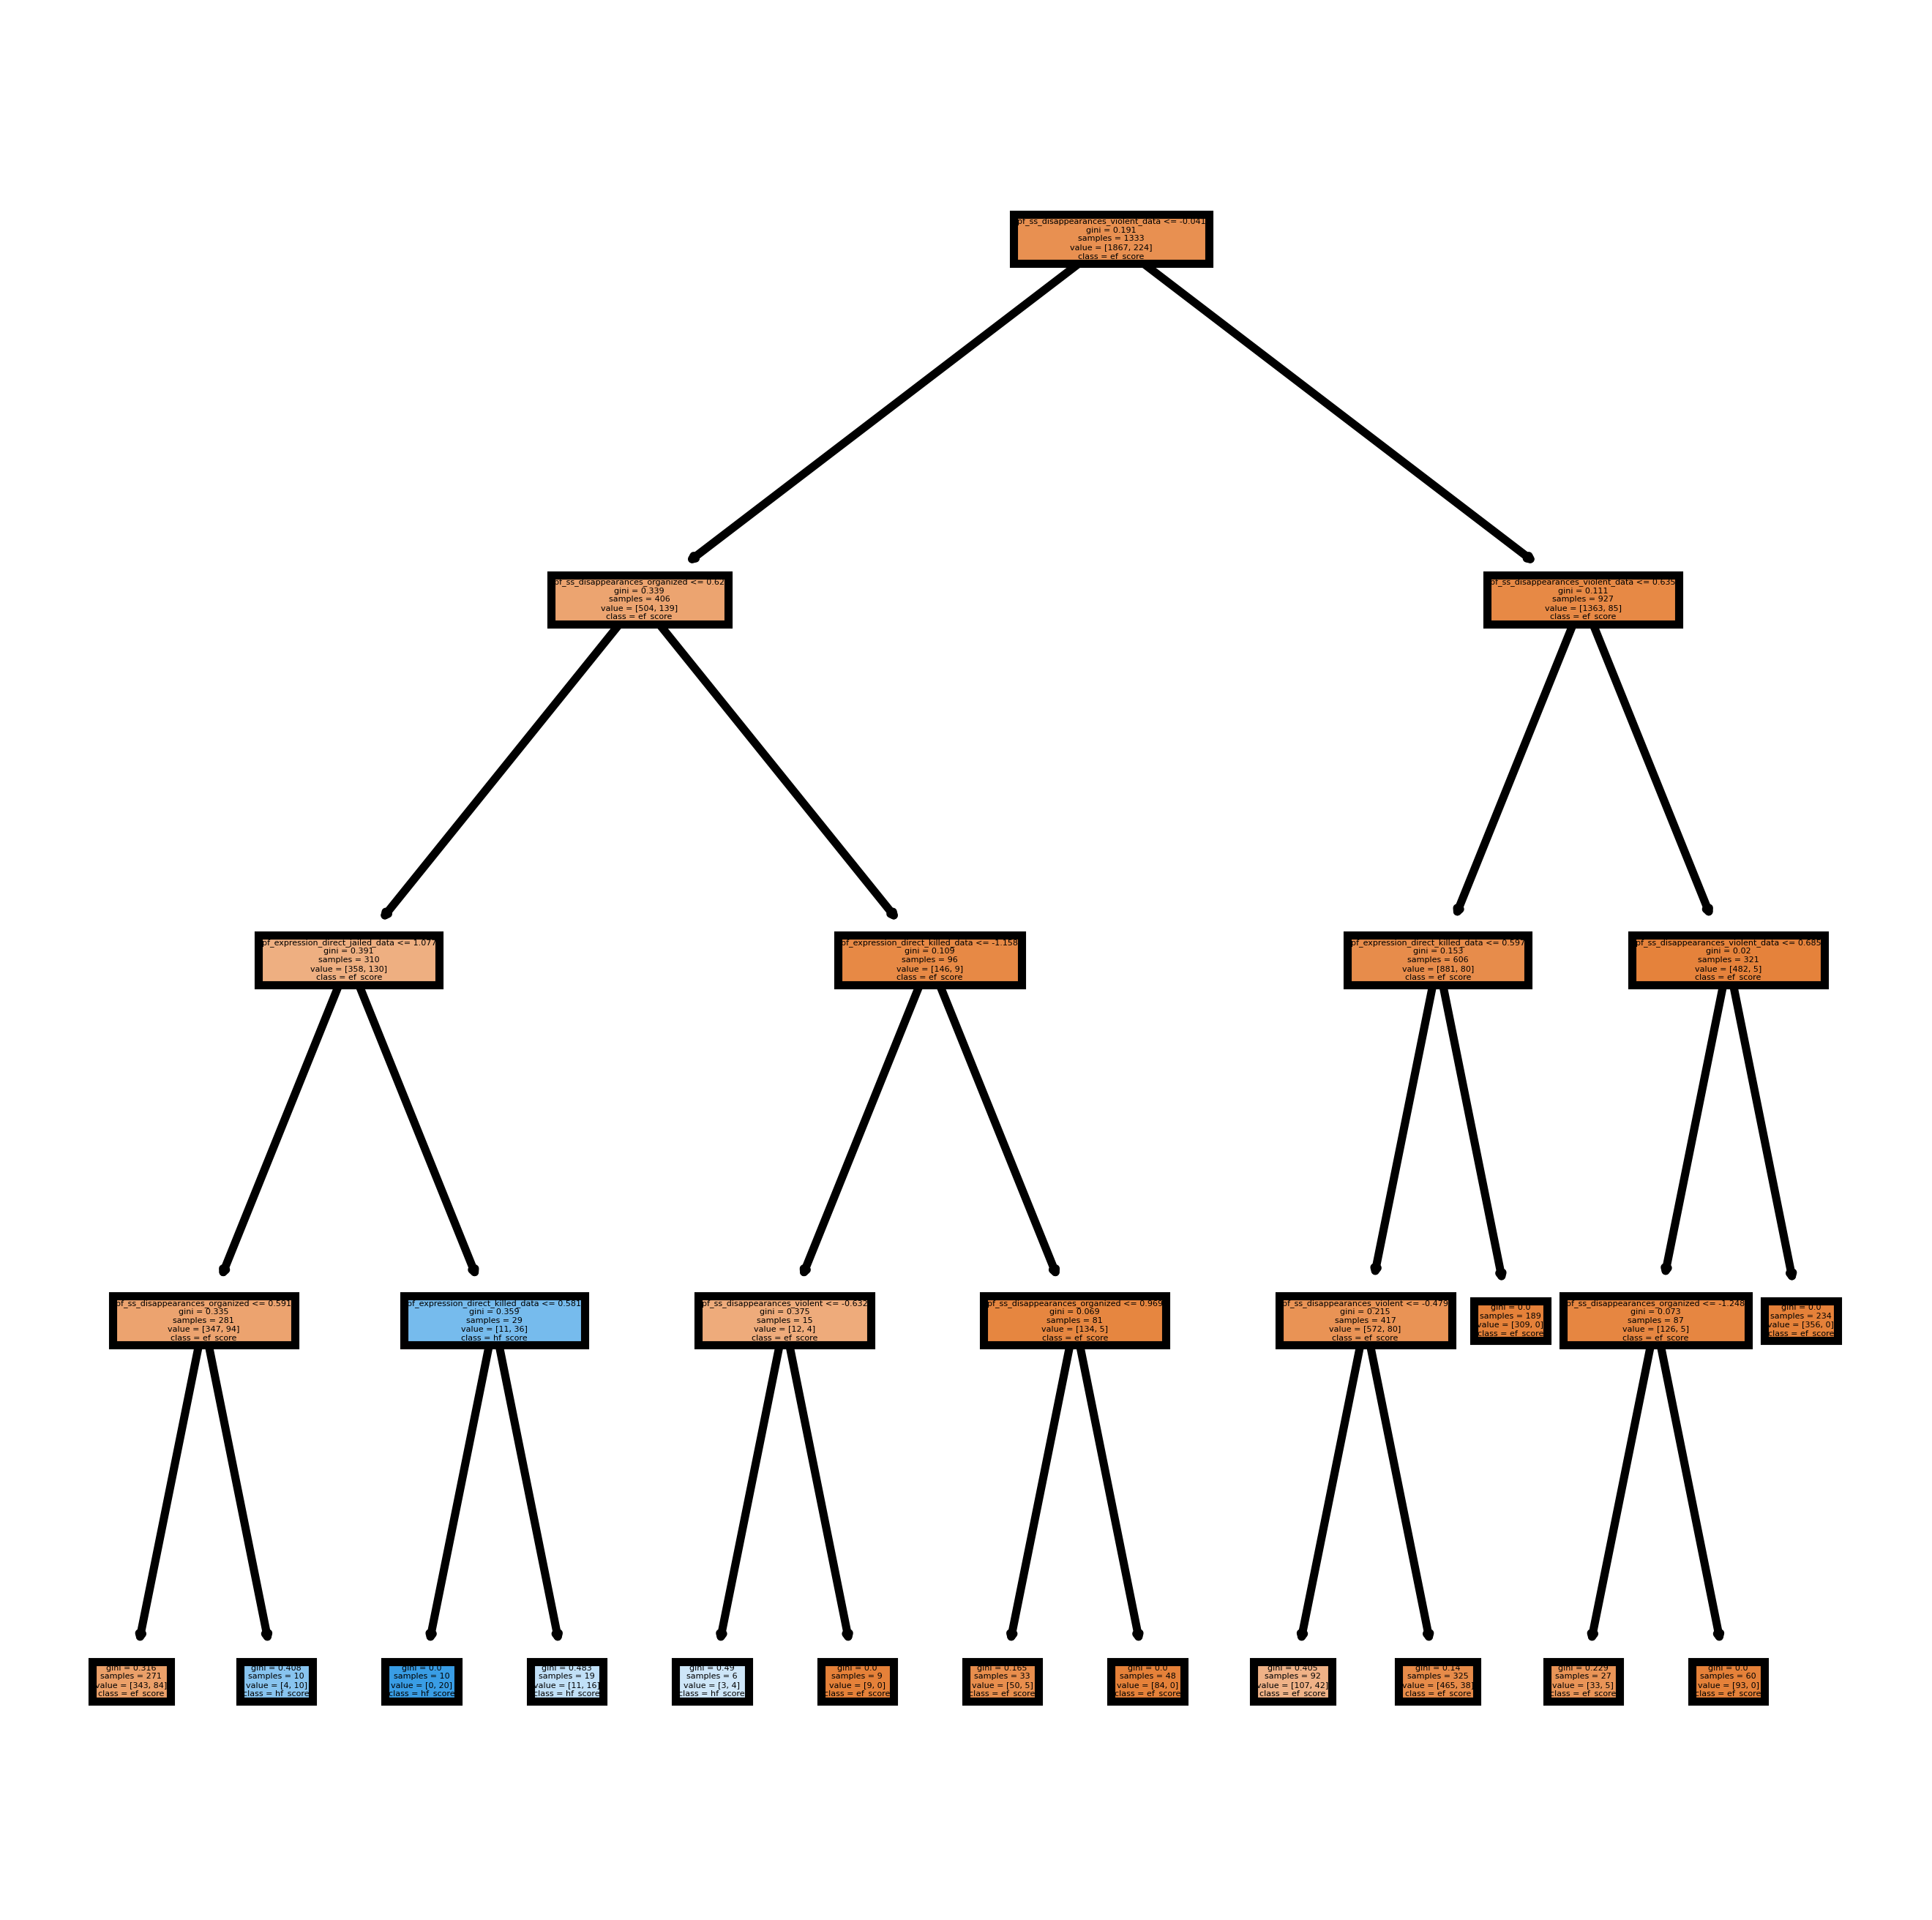

In [24]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Choose a tree from the random forest model
# Here we're choosing the first tree, but you can choose any tree
model = best_models_rf_temporal["ef_score"].estimators_[0]

fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=800)
plot_tree(model,
          feature_names = X_temp_train.columns, 
          class_names=y_temp_train.columns,
          filled = True)


### Neural Network

In this version of the code, I've added more hidden layers and neurons per layer to the hidden_layer_sizes parameter. The tuples in the hidden_layer_sizes list now represent the number of neurons in each layer of the network. For example, (50, 50) represents a network with two hidden layers, each containing 50 neurons. (100, 50) represents a network with two hidden layers, the first containing 100 neurons and the second containing 50.

I've also added the alpha parameter to the hyperparameter grid. This parameter controls the amount of L2 regularization applied to the network, which can help to prevent overfitting by penalizing large weights in the network. Adding this parameter to the grid search can help to find the optimal balance between model complexity and overfitting.

## Modelling: Spatial

### Spatial Random Forest and XGBoost and Neural Network

### Bayesian Spatio-Temporal Interaction (BSTI) and  MGWR / GWR

## Modelling: Genetic

In [25]:
from tpot import TPOTClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier
from lightgbm import LGBMClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

# Initialize dictionaries to store models and their feature importances
models = {}
feature_importances = {}

# Create a time series split object
tscv = TimeSeriesSplit(n_splits=5)

# Define the search space for models and hyperparameters with expanded ranges
tpot_config = {
    'sklearn.ensemble.AdaBoostClassifier': {
        'n_estimators': range(50, 251, 50),
        'learning_rate': [0.01, 0.1, 1],
        'base_estimator': [
            DecisionTreeClassifier(max_depth=1),
            DecisionTreeClassifier(max_depth=2),
            DecisionTreeClassifier(max_depth=3)
        ]
    },
    'sklearn.ensemble.RandomForestClassifier': {
        'n_estimators': range(100, 401, 100),
        'max_depth': [3, 5, 7, None],
        'min_samples_split': range(2, 11, 2)
    },
    'sklearn.svm.SVC': {
        'C': [0.1, 1.0, 10.0],
        'kernel': ['linear', 'rbf']
    },
    'sklearn.ensemble.GradientBoostingClassifier': {
        'n_estimators': range(50, 251, 50),
        'learning_rate': [0.01, 0.1, 1],
        'max_depth': [3, 5, 7]
    },
    'xgboost.XGBClassifier': {
        'n_estimators': range(50, 251, 50),
        'learning_rate': [0.01, 0.1, 1],
        'max_depth': [3, 5, 7]
    },
    'lightgbm.LGBMClassifier': {
        'n_estimators': range(50, 251, 50),
        'learning_rate': [0.01, 0.1, 1],
        'max_depth': [3, 5, 7]
    },
    'sklearn.naive_bayes.GaussianNB': {
    },
    'sklearn.ensemble.ExtraTreesClassifier': {
        'n_estimators': range(100, 401, 100),
        'max_depth': [3, 5, 7, None],
        'min_samples_split': range(2, 11, 2)
    },
    'sklearn.ensemble.BaggingClassifier': {
        'n_estimators': range(10, 101, 20),
        'base_estimator': [None, DecisionTreeClassifier(max_depth=3), DecisionTreeClassifier(max_depth=5)]
    }
}

for target, best_features in selected_features_dict.items():
    print(f"Training model for {target}")

    # Subset X_train and X_test to only include the best features
    X_train_best = X_train[best_features]
    X_test_best = X_test[best_features]

    # Initialize TPOT with the desired configuration
    tpot = TPOTClassifier(generations=20, population_size=100, cv=tscv, config_dict=tpot_config, random_state=0, verbosity=2)

    # Fit TPOT to the training data with the best features
    tpot.fit(X_train_best, y_train[target])

    # Store the best pipeline found by TPOT for the target
    best_pipeline = tpot.fitted_pipeline_
    models[target] = best_pipeline

    # Check if the model has feature_importances_ attribute
    if hasattr(best_pipeline.steps[-1][1], "feature_importances_"):
        # Get feature importances
        importances = best_pipeline.steps[-1][1].feature_importances_
        # Match importances with feature names
        feature_importance_dict = dict(zip(best_features, importances))
        feature_importances[target] = feature_importance_dict
    else:
        print(f"The best model for target {target} does not support feature importances")

    # Make predictions on the test set with the best features
    y_pred = tpot.predict(X_test_best)

    # Generate classification report
    report = classification_report(y_test[target], y_pred)
    
        # Print classification report
    print(f"Classification Report for {target}:")
    print(report)

# After the loop, you can print out the feature importances
for target, importance_dict in feature_importances.items():
    print(f"\nFeature importances for target {target}:")
    for feature, importance in sorted(importance_dict.items(), key=lambda item: item[1], reverse=True):
        print(f"Feature: {feature}, Importance: {importance}")

NameError: name 'selected_features_dict' is not defined

In [ ]:
from tpot import TPOTClassifier
from sklearn.model_selection import TimeSeriesSplit

# Define the cross-validation procedure
tscv = TimeSeriesSplit(n_splits=5)

# Initialize the TPOT classifier
tpot = TPOTClassifier(generations=5, population_size=50, verbosity=2,
                      scoring='accuracy', cv=tscv, random_state=42,
                      config_dict='TPOT light')

# Perform optimization and feature selection for each target
for target in y_train.columns:
    tpot.fit(X_train_numeric, y_train[target])
    print(f"Best pipeline for target {target} is: \n{tpot.fitted_pipeline_}")

# Export the pipeline for each target as a Python script file
tpot.export('optimized_pipeline.py')